Code copied from knn_lacounty_biggersample and adjusted to include more variables in model, and get the model to run on more data


In [1]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values
import matplotlib.pyplot as plt

In [2]:
# Change these variables to suit local database and associated Postgresql username and password 
host_name ='ec2-52-201-66-148.compute-1.amazonaws.com'
db_name = 'd44ns4ruujn4nq'
username =  'ub5debmb55aodh'
pw = 'pe6a56f3002c3f1181d1a34e26d9a90636fdd56e1156bf39a6b8ff158a49bf163'
tablename = 'cleanlacountytable'


In [3]:
# Connect to local database
try:
        conn = psycopg2.connect(host = host_name, database=db_name, port = 5432, user=username, password=pw)
        print("successfully connected to database")
except:
        print("I am unable to connect to the database")

successfully connected to database


In [4]:
# Create dataframe
df = pd.read_sql_query('select * from ' + tablename, con=conn)

In [12]:
list(df)

['zipcode',
 'taxratearea_city',
 'ain',
 'rollyear',
 'taxratearea',
 'assessorid',
 'propertylocation',
 'propertytype',
 'propertyusecode',
 'generalusetype',
 'specificusetype',
 'specificusedetail1',
 'specificusedetail2',
 'totbuildingdatalines',
 'yearbuilt',
 'effectiveyearbuilt',
 'sqftmain',
 'bedrooms',
 'bathrooms',
 'units',
 'recordingdate',
 'landvalue',
 'landbaseyear',
 'improvementvalue',
 'impbaseyear',
 'totallandimpvalue',
 'homeownersexemption',
 'realestateexemption',
 'fixturevalue',
 'fixtureexemption',
 'personalpropertyvalue',
 'personalpropertyexemption',
 'istaxableparcel',
 'totalvalue',
 'totalexemption',
 'nettaxablevalue',
 'specialparcelclassification',
 'administrativeregion',
 'cluster',
 'parcelboundarydescription',
 'houseno',
 'housefraction',
 'streetdirection',
 'streetname',
 'unitno',
 'city',
 'zipcode5',
 'rowid',
 'center_lat',
 'center_lon',
 'usecode1',
 'usecode2',
 'usecode3',
 'usecode4']

In [13]:
# Make dataframe with variables we are going to use
X = pd.DataFrame(df[['landbaseyear','center_lat', 'center_lon', 'yearbuilt', 'effectiveyearbuilt','landvalue','sqftmain']])

In [17]:
# Preliminary cleaning
for col in X:
    # Removes any row where column value is ''
    X = X[X[col]!= ''] 
    
    # Change data type to int and float
    if col == 'landbaseyear':
        X[col] = X[col].astype(int)
    else:
        X[col] = X[col].astype(float)

# Add land value per square foot to dataframe
X['landvaluepersqft'] = X['landvalue']/X['sqftmain']
X.head()

,landbaseyear,center_lat,center_lon,yearbuilt,effectiveyearbuilt,landvalue,sqftmain,landvaluepersqft
0,1986,34.010051,-118.480648,1926.0,1952.0,426590.0,4193.0,101.738612
1,2004,34.009479,-118.479976,1924.0,1943.0,1697932.0,7032.0,241.457907
2,1975,33.997109,-118.479916,1968.0,1968.0,51223.0,1746.0,29.337342
3,2004,33.996227,-118.481251,1913.0,1932.0,1379570.0,3262.0,422.921521
4,1975,34.003211,-118.485110,1975.0,1975.0,52868.0,3872.0,13.653926


In [19]:
# Clean data
X= X[X['sqftmain'] != 0]
X= X[X['landvaluepersqft'] < 1000]
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
len(X)

1153244

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [21]:
# Set independent and dependent variables
y = pd.DataFrame(X['landvaluepersqft'])
X.drop(['landvalue', 'sqftmain', 'landvaluepersqft'], axis=1)

,landbaseyear,center_lat,center_lon,yearbuilt,effectiveyearbuilt
0,1986,34.010051,-118.480648,1926.0,1952.0
1,2004,34.009479,-118.479976,1924.0,1943.0
2,1975,33.997109,-118.479916,1968.0,1968.0
3,2004,33.996227,-118.481251,1913.0,1932.0
4,1975,34.003211,-118.485110,1975.0,1975.0
...,...,...,...,...,...
1170676,2008,34.014866,-118.279099,1925.0,1925.0
1170677,1975,34.016274,-118.279038,1957.0,1957.0
1170678,2004,34.015590,-118.279535,1925.0,1936.0
1170679,2001,34.017439,-118.278295,1966.0,1984.0


In [23]:
# Split data randomly - 30% used for test data; 70% used for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Create kNN Model
knn= KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=10)

In [25]:
# Create predictions for test data
y_pred = knn.predict(X_test)

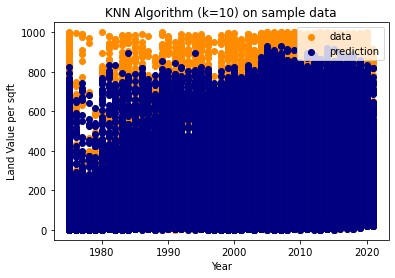

In [28]:
# Evaluate model
plt.scatter(X_test['landbaseyear'], y_test, color="darkorange", label="data")
plt.scatter(X_test['landbaseyear'], y_pred, color="navy", label="prediction")
plt.legend(loc=1)
plt.xlabel('Year')
plt.ylabel('Land Value per sqft')
plt.title("KNN Algorithm (k=10) on sample data")
plt.show()

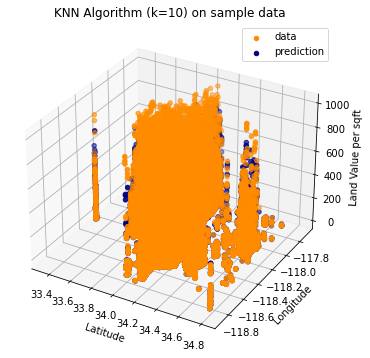

In [30]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_test['center_lat'], X_test['center_lon'], y_test, color="darkorange", label="data")
ax.scatter3D(X_test['center_lat'], X_test['center_lon'], y_pred, color="navy", label="prediction")
ax.legend(loc=1)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Land Value per sqft')
plt.title("KNN Algorithm (k=10) on sample data")
plt.show()

In [31]:
error = sqrt(mean_squared_error(y_test,y_pred))
error

22.006722095941097

In [34]:
# Create a dataframe that contains all columns, but only rows where landbaseyear is 2021
X_assess = X.copy()
X_assess = X_assess[X_assess['landbaseyear'] == 2021]


,landbaseyear,center_lat,center_lon,yearbuilt,effectiveyearbuilt,landvalue,sqftmain,landvaluepersqft
316417,2021,33.993253,-117.870492,1983.0,1983.0,3200000.0,23400.0,136.752137
316464,2021,33.995364,-117.885019,1992.0,1992.0,1664000.0,10601.0,156.966324
316473,2021,34.036044,-117.925917,2007.0,2007.0,2120668.0,6357.0,333.595721
316479,2021,34.044409,-117.926517,1961.0,1961.0,550000.0,4800.0,114.583333
316562,2021,34.003488,-117.886742,2009.0,2009.0,260000.0,1150.0,226.086957
...,...,...,...,...,...,...,...,...
390003,2021,34.153500,-118.657165,2003.0,2003.0,4000000.0,78495.0,50.958660
390032,2021,34.144595,-118.747336,2007.0,2007.0,9120005.0,98734.0,92.369447
390104,2021,34.165227,-118.623971,1961.0,1961.0,2700000.0,6466.0,417.568822
390261,2021,34.194321,-118.606734,1963.0,1964.0,3600000.0,21871.0,164.601527


In [35]:
# Set dependent and independent varaibles for the properties that were assessed in 2021 (y_assess_pred), 
y_assess = pd.DataFrame(X_assess['landvaluepersqft'])
X_assess.drop(['landvalue', 'sqftmain', 'landvaluepersqft'], axis=1)

,landbaseyear,center_lat,center_lon,yearbuilt,effectiveyearbuilt
316417,2021,33.993253,-117.870492,1983.0,1983.0
316464,2021,33.995364,-117.885019,1992.0,1992.0
316473,2021,34.036044,-117.925917,2007.0,2007.0
316479,2021,34.044409,-117.926517,1961.0,1961.0
316562,2021,34.003488,-117.886742,2009.0,2009.0
...,...,...,...,...,...
390003,2021,34.153500,-118.657165,2003.0,2003.0
390032,2021,34.144595,-118.747336,2007.0,2007.0
390104,2021,34.165227,-118.623971,1961.0,1961.0
390261,2021,34.194321,-118.606734,1963.0,1964.0


In [36]:
# Make predictions for the properties that were assessed in 2021
y_assess_pred = knn.predict(X_assess)

In [37]:
# Compare predictions to actual values
print("For properties assessed in 2021")
print("Mean predicted LV/sqft: ", y_assess_pred.mean())
print("Mean actual LV/sqft: ", y_assess['landvaluepersqft'].mean())
print("St. Dev of predicted LV/sqft: ", y_assess_pred.std())
print("St. Dev of actual LV/sqft: ", y_assess['landvaluepersqft'].std())
print("Mean error: ", sqrt(mean_squared_error(y_assess,y_assess_pred)))

For properties assessed in 2021
Mean predicted LV/sqft:  260.59183396148404
Mean actual LV/sqft:  265.20060466723015
St. Dev of predicted LV/sqft:  171.64057539673684
St. Dev of actual LV/sqft:  185.94905792569634
Mean error:  37.56342985722669


In [38]:
# Create a copy of X, but with all landbaseyear values replaced with 2021
X_current = X.copy()
X_current["landbaseyear"] = 2021
X_current

,landbaseyear,center_lat,center_lon,yearbuilt,effectiveyearbuilt,landvalue,sqftmain,landvaluepersqft
0,2021,34.010051,-118.480648,1926.0,1952.0,426590.0,4193.0,101.738612
1,2021,34.009479,-118.479976,1924.0,1943.0,1697932.0,7032.0,241.457907
2,2021,33.997109,-118.479916,1968.0,1968.0,51223.0,1746.0,29.337342
3,2021,33.996227,-118.481251,1913.0,1932.0,1379570.0,3262.0,422.921521
4,2021,34.003211,-118.485110,1975.0,1975.0,52868.0,3872.0,13.653926
...,...,...,...,...,...,...,...,...
1170676,2021,34.014866,-118.279099,1925.0,1925.0,407033.0,12732.0,31.969290
1170677,2021,34.016274,-118.279038,1957.0,1957.0,78992.0,61344.0,1.287689
1170678,2021,34.015590,-118.279535,1925.0,1936.0,1046389.0,24588.0,42.556898
1170679,2021,34.017439,-118.278295,1966.0,1984.0,485267.0,32862.0,14.766813


In [39]:
# Predict land value for each property if it were assessed in 2021 based on latitude and longitude
y_current = knn.predict(X_current)

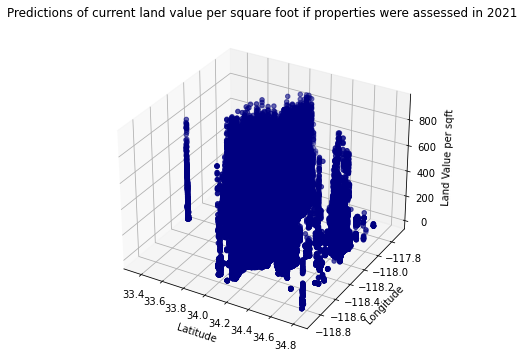

In [40]:
# Plot the predictions for land value per sqft if properties were assessed in 2021
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_current['center_lat'], X_current['center_lon'], y_current, color="navy")
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Land Value per sqft')
plt.title("Predictions of current land value per square foot if properties were assessed in 2021")
plt.show()